In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import yaml

import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
lemma = WordNetLemmatizer()

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfTransformer , CountVectorizer
from sklearn.metrics import confusion_matrix , accuracy_score 
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC 
from sklearn.naive_bayes import MultinomialNB 

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
from keras.models import Sequential
from keras.layers import Dense, Dropout , Embedding ,SimpleRNN
from keras.callbacks import EarlyStopping 

from joblib import dump 

nltk.download('stopwords') # download stopwords

[nltk_data] Downloading package stopwords to C:\Users\Mohamed
[nltk_data]     Nabil\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [2]:
file = Path('..\data\intents.yaml') 

In [3]:
patterns_lst = []
tags_lst = []


# Read data from file
data_file = open(file).read()
intents = yaml.safe_load(data_file)

for intent in intents['intent']:
    for pattern in intent['patterns']:
        patterns_lst.append(pattern)
        tags_lst.append(intent['tag'])
        
dataset = {'Sentence':patterns_lst , 'Intent':tags_lst}

# Create dataframe
df = pd.DataFrame(data=dataset)
df.sample(10)

,Sentence,Intent
418,dim the lights,Iot
769,how do you make spaghetti,Cooking
403,make lights brightener,Iot
960,let me hear the song sympathy for the devil,PlayMusic
211,what time is it in london now,Datetime
149,Do you have the time?,Datetime
1048,i like top forty music,PlayMusic
227,Is it humid out there today?,Weather
261,is it going to rain,Weather
814,what temperature should a baked chicken be,Cooking


In [4]:
df.shape

(1298, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1298 entries, 0 to 1297
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  1298 non-null   object
 1   Intent    1298 non-null   object
dtypes: object(2)
memory usage: 20.4+ KB


In [6]:
print('Number of unique sentences:' , df['Sentence'].nunique())

Number of unique sentences: 1237


In [7]:
print('Number of intents:' , df['Intent'].nunique())

Number of intents: 11


In [8]:
classes = sorted(list(set(df['Intent'])))
classes         

['Cooking',
 'Datetime',
 'Goodbye',
 'Greeting',
 'Iot',
 'Joke',
 'News',
 'PlayMusic',
 'Reminder',
 'Thanks',
 'Weather']

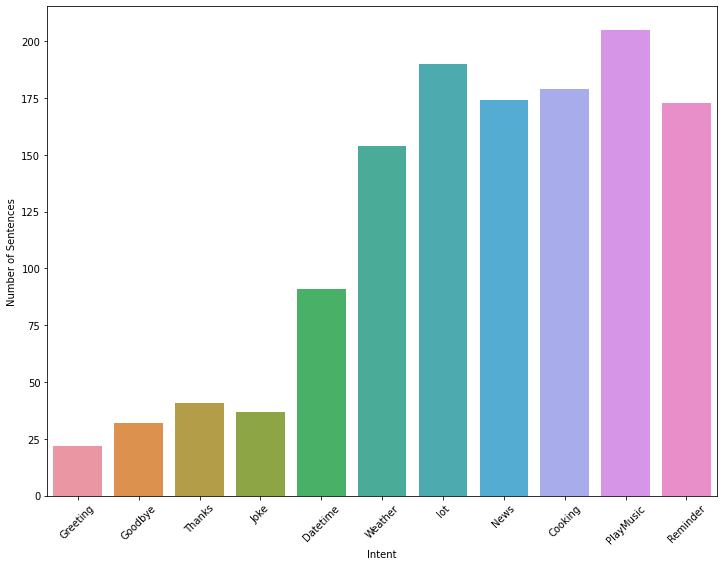

In [9]:
plt.figure(figsize=(12,9))
sns.countplot(x = 'Intent' , data = df)
plt.xticks(rotation=45)
plt.ylabel('Number of Sentences')
plt.show()

In [10]:
def preprocess(dataframe):
    data = []
    for i in range(dataframe.shape[0]):
        sentence = dataframe.iloc[i, 0]

        # remove non alphabatic characters
        sentence = re.sub('[^A-Za-z]', ' ', sentence)

        # make words lowercase
        sentence = sentence.lower()

        # tokenize words
        tokenized_sentence = word_tokenize(sentence)

        # remove stop words and lemmatize
        sentence_processed = []
        
        for word in tokenized_sentence:
            if word not in set(stopwords.words('english')):
                sentence_processed.append(lemma.lemmatize(word , pos='n')) # lemmatize words with noun  

        sentence_text = " ".join([lemma.lemmatize(word, pos='v') for word in sentence_processed]) # lemmatize words with verb 
        data.append(sentence_text)
    
    return data

## ML Model


In [11]:
X = preprocess(df)
y = df.iloc[:, 1]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2 , random_state=0 , stratify=y ,shuffle=True)

In [13]:
svc_model = Pipeline([   ('vect', CountVectorizer(ngram_range=(1,2),max_features=1000,max_df=.70)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', LinearSVC(random_state=0, tol=1e-5))
                     ]
                    )

svc_model.fit(X_train, y_train)

y_pred = svc_model.predict(X_test)

print('Training Accuracy:',round(svc_model.score(X_train,y_train)*100,2),'%')
print('Testing Accuracy:',round(accuracy_score(y_test,y_pred)*100,2),'%')

Training Accuracy: 99.33 %
Testing Accuracy: 98.85 %


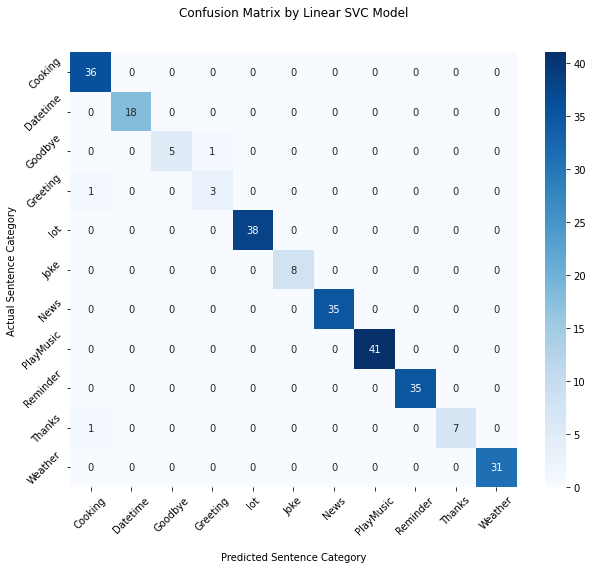

In [14]:
matrix = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(10,8))
ax = sns.heatmap(matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix by Linear SVC Model\n\n');
ax.set_xlabel('\nPredicted Sentence Category')
ax.set_ylabel('Actual Sentence Category');

ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

In [15]:
nb_model = Pipeline([    ('vect', CountVectorizer(ngram_range=(1,2),max_df=.70)),
                         ('tfidf', TfidfTransformer()),
                         ('nb', MultinomialNB())
                    ]
                   )

nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)

print('Training Accuracy:',round(svc_model.score(X_train,y_train)*100,2),'%')
print('Testing Accuracy:',round(accuracy_score(y_test,y_pred)*100,2),'%')

Training Accuracy: 99.33 %
Testing Accuracy: 93.85 %


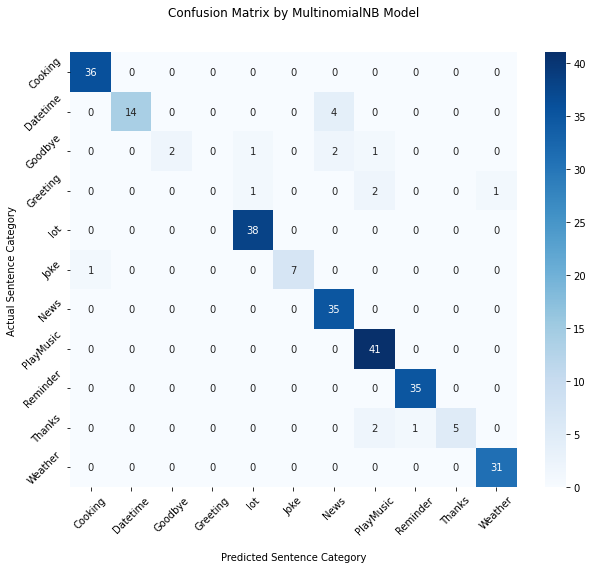

In [16]:
matrix = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(10,8))
ax = sns.heatmap(matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix by MultinomialNB Model\n\n');
ax.set_xlabel('\nPredicted Sentence Category')
ax.set_ylabel('Actual Sentence Category');

ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

In [17]:
# dump the pipeline model
dump(svc_model, filename="SVC_Model.joblib")

['SVC_Model.joblib']

## DL Model

### Using BOW Model

##### Transforming texts into vectors
##### Vocabulary Vector
    Vocabulary is a mapping (dict) from words to indices (integers). It represents ALL the words in a language. But it's hard to get ALL words,
    so we count only what we have in a dataset/corpus.Since we don't account for all words, we might encounter 
    Out-Of-Vocab words which we dont know a mapping for. So we usually reserve a special token index for UNKnown words.

#### Using Keras Tokenizer to convert a sequence of words into integers.

In [18]:
token = Tokenizer()
token.fit_on_texts(preprocess(df))
words =  token.word_index
words

{'please': 1,
 'play': 2,
 'news': 3,
 'light': 4,
 'tell': 5,
 'weather': 6,
 'today': 7,
 'time': 8,
 'music': 9,
 'alarm': 10,
 'turn': 11,
 'set': 12,
 'recipe': 13,
 'make': 14,
 'song': 15,
 'latest': 16,
 'cook': 17,
 'go': 18,
 'like': 19,
 'bedroom': 20,
 'week': 21,
 'room': 22,
 'want': 23,
 'need': 24,
 'show': 25,
 'playlist': 26,
 'joke': 27,
 'thank': 28,
 'new': 29,
 'tomorrow': 30,
 'brightness': 31,
 'event': 32,
 'find': 33,
 'live': 34,
 'good': 35,
 'day': 36,
 'next': 37,
 'current': 38,
 'date': 39,
 'chicken': 40,
 'know': 41,
 'give': 42,
 'whats': 43,
 'put': 44,
 'happen': 45,
 'meet': 46,
 'hear': 47,
 'right': 48,
 'read': 49,
 'morning': 50,
 'forecast': 51,
 'get': 52,
 'world': 53,
 'let': 54,
 'temperature': 55,
 'heat': 56,
 'calendar': 57,
 'headline': 58,
 'rock': 59,
 'jazz': 60,
 'listen': 61,
 'york': 62,
 'medium': 63,
 'talk': 64,
 'bbc': 65,
 'call': 66,
 'remind': 67,
 'outside': 68,
 'add': 69,
 'remove': 70,
 'would': 71,
 'pm': 72,
 'pasta'

In [19]:
vocab_size = len(token.word_index) + 1
vocab_size

762

In [20]:
text = 'please open the door'
x = token.texts_to_sequences([text.split()])
print(x , '\n',np.array(x).shape)

[[1, 80, 126]] 
 (1, 3)


#### Build a simple BoW.
    Rows are the number of sentences.
    Columns are the number of words in the vocab.

Can encode different modes:

    binary: Whether or not each word is present in the document. 
    count: The count of each word in the document.
    tfidf: The Text Frequency-Inverse Document Frequency (TF-IDF) scoring for each word in the document.
    freq: The frequency of each word as a ratio of words within each document.

In [21]:
bow = token.texts_to_matrix(preprocess(df), mode='freq')
bow.shape

(1298, 762)

Using **Frequency** mode to prevent overfitting not like **TF-IDF** mode it doesn't make normailze 


In [22]:
bow[555]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [23]:
y_encoded = np.array(df['Intent']).reshape(len(df), 1)
y_encoded.shape


(1298, 1)

In [24]:
encoder = OneHotEncoder(sparse = False)
y = encoder.fit_transform(y_encoded)
y.shape

(1298, 11)

In [25]:
X_train , X_test , y_train , y_test = train_test_split(bow , y , test_size = 0.2 , random_state = 0 , stratify = y , shuffle = True)

In [26]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((1038, 762), (260, 762), (1038, 11), (260, 11))

In [27]:
model = Sequential()
model.add(Dense(128, input_shape=(vocab_size,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               97664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 11)                715       
                                                                 
Total params: 106,635
Trainable params: 106,635
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compile the model with categorical_crossentropy loss and adam optimizer
model.compile(loss='categorical_crossentropy', optimizer = 'adam' , metrics=['accuracy'])

In [29]:
history = model.fit(X_train, y_train, epochs=100, batch_size=5, validation_data=(X_test, y_test))

Epoch 1/100
208/208 [==============================] - 3s 6ms/step - loss: 2.2177 - accuracy: 0.2659 - val_loss: 1.8589 - val_accuracy: 0.6231
Epoch 2/100
208/208 [==============================] - 0s 2ms/step - loss: 1.4637 - accuracy: 0.6435 - val_loss: 0.8717 - val_accuracy: 0.8231
Epoch 3/100
208/208 [==============================] - 0s 2ms/step - loss: 0.7672 - accuracy: 0.8064 - val_loss: 0.4623 - val_accuracy: 0.9154
Epoch 4/100
208/208 [==============================] - 0s 2ms/step - loss: 0.4852 - accuracy: 0.8690 - val_loss: 0.2989 - val_accuracy: 0.9462
Epoch 5/100
208/208 [==============================] - 0s 2ms/step - loss: 0.3553 - accuracy: 0.9046 - val_loss: 0.2106 - val_accuracy: 0.9769
Epoch 6/100
208/208 [==============================] - 1s 3ms/step - loss: 0.2641 - accuracy: 0.9374 - val_loss: 0.1503 - val_accuracy: 0.9846
Epoch 7/100
208/208 [==============================] - 1s 2ms/step - loss: 0.1896 - accuracy: 0.9528 - val_loss: 0.1110 - val_accuracy: 0.9846

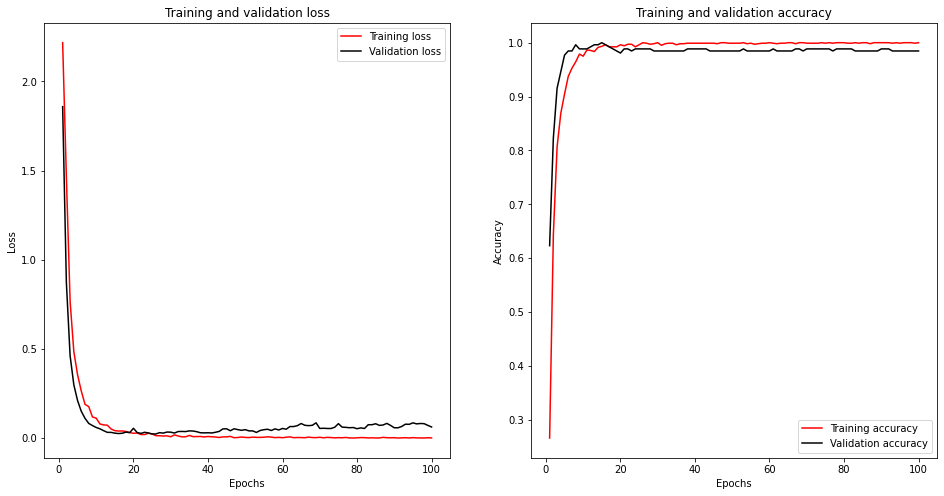

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(16, 8))
# Adds a subplot at the 1st position
fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'black', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
  
# Adds a subplot at the 2nd position
fig.add_subplot(1, 2, 2)
plt.plot(epochs, acc, 'red', label='Training accuracy')
plt.plot(epochs, val_acc, 'black', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()



In [31]:
model.save('BOW.h5',history)

#### Using RNN Model

In [32]:
# Get maximum length of sentence
max_len = max([len(x) for x in df['Sentence']])
max_len

70

In [33]:
# Create Padding of maximum length for all sentences to make them of same length
l = np.array(pad_sequences(token.texts_to_sequences(df['Sentence']), maxlen=50, padding='post', truncating='post'))
l.shape


(1298, 50)

In [34]:
X_train , X_test , y_train , y_test = train_test_split(l , y , test_size = 0.2 , random_state = 0 , stratify = y , shuffle = True)

In [35]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((1038, 50), (260, 50), (1038, 11), (260, 11))

In [36]:
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length = 50))
model.add(SimpleRNN(64,activation='relu'))
model.add(Dense(len(classes), activation = "softmax"))

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            48768     
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 11)                715       
                                                                 
Total params: 57,739
Trainable params: 57,739
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(X_train, y_train, epochs=100, batch_size=5, validation_data=(X_test, y_test), verbose=1,callbacks=[EarlyStopping()])

Epoch 1/100
208/208 [==============================] - 4s 11ms/step - loss: 2.2504 - accuracy: 0.1570 - val_loss: 2.1982 - val_accuracy: 0.1577
Epoch 2/100
208/208 [==============================] - 3s 13ms/step - loss: 2.2136 - accuracy: 0.1464 - val_loss: 2.1993 - val_accuracy: 0.1577


In [38]:
import pickle
pickle.dump(classes, open("..\data\classes.pkl", "wb"))
pickle.dump(words, open("..\data\words.pkl", "wb"))
